In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1640999100000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [5]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

                Close_Time     Open    Close     High      Low     Volume
0      2022-01-01 09:29:59  3727.61  3737.77  3748.45  3726.09  3031.6975
1      2022-01-01 09:44:59  3737.77  3733.82  3743.02  3732.47  1450.1718
2      2022-01-01 09:59:59  3733.83  3724.89  3734.22  3722.23  2228.9498
3      2022-01-01 10:14:59  3724.88  3726.49  3730.33  3723.00  1170.2247
4      2022-01-01 10:29:59  3726.58  3729.16  3738.47  3726.54  1410.2047
...                    ...      ...      ...      ...      ...        ...
43157  2023-03-26 23:59:59  1762.60  1762.81  1767.22  1760.25  4219.0347
43158  2023-03-27 00:14:59  1762.81  1763.59  1767.77  1761.55  3301.4893
43159  2023-03-27 00:29:59  1763.58  1762.51  1763.87  1760.34  3025.0612
43160  2023-03-27 00:44:59  1762.50  1762.50  1764.84  1761.94  1798.9692
43161  2023-03-27 00:59:59  1762.49  1759.66  1763.61  1756.61  3283.4845

[43162 rows x 6 columns]


In [6]:
df = raw_df.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slow_k'] < df['slow_d']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

                Close_Time     Open    Close     High      Low     Volume  \
0      2022-01-01 09:29:59  3727.61  3737.77  3748.45  3726.09  3031.6975   
1      2022-01-01 09:44:59  3737.77  3733.82  3743.02  3732.47  1450.1718   
2      2022-01-01 09:59:59  3733.83  3724.89  3734.22  3722.23  2228.9498   
3      2022-01-01 10:14:59  3724.88  3726.49  3730.33  3723.00  1170.2247   
4      2022-01-01 10:29:59  3726.58  3729.16  3738.47  3726.54  1410.2047   
...                    ...      ...      ...      ...      ...        ...   
43157  2023-03-26 23:59:59  1762.60  1762.81  1767.22  1760.25  4219.0347   
43158  2023-03-27 00:14:59  1762.81  1763.59  1767.77  1761.55  3301.4893   
43159  2023-03-27 00:29:59  1763.58  1762.51  1763.87  1760.34  3025.0612   
43160  2023-03-27 00:44:59  1762.50  1762.50  1764.84  1761.94  1798.9692   
43161  2023-03-27 00:59:59  1762.49  1759.66  1763.61  1756.61  3283.4845   

             ema_8       ema_18       ema_38       atr        rsi     slow_

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] <= df['ema_38']
        
        df['c5'] = df['rsi'] <= 40

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,...,slow_k,slow_d,kd_cross,c1,c2,c3,c4,c5,signal,open_entry
0,2022-01-01 09:29:59,3727.61,3737.77,3748.45,3726.09,3031.6975,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-01-01 09:44:59,3737.77,3733.82,3743.02,3732.47,1450.1718,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
2,2022-01-01 09:59:59,3733.83,3724.89,3734.22,3722.23,2228.9498,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
3,2022-01-01 10:14:59,3724.88,3726.49,3730.33,3723.00,1170.2247,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
4,2022-01-01 10:29:59,3726.58,3729.16,3738.47,3726.54,1410.2047,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43157,2023-03-26 23:59:59,1762.60,1762.81,1767.22,1760.25,4219.0347,1768.866393,1771.572670,1768.507479,8.721640,...,20.404335,23.780742,False,False,True,True,False,False,False,False
43158,2023-03-27 00:14:59,1762.81,1763.59,1767.77,1761.55,3301.4893,1767.693861,1770.732389,1768.255301,8.542952,...,22.030013,20.807281,True,True,True,True,False,False,False,False
43159,2023-03-27 00:29:59,1763.58,1762.51,1763.87,1760.34,3025.0612,1766.541892,1769.866874,1767.960670,8.184884,...,19.779075,20.737807,True,True,True,True,False,False,False,False
43160,2023-03-27 00:44:59,1762.50,1762.50,1764.84,1761.94,1798.9692,1765.643694,1769.091414,1767.680636,7.807392,...,19.758233,20.522440,False,False,True,True,False,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and entry_df.at[index, 'Close'] > stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (entry_df.at[index, 'Low'] <= close_val.shift(1).at[index] - 4 * atr_val.shift(1).at[index]) and in_position == True:
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan

entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


                Close_Time     Open    Close     High      Low     Volume  \
37     2022-01-01 18:44:59  3691.22  3698.61  3699.97  3673.46  3851.5917   
38     2022-01-01 18:59:59  3698.61  3691.39  3707.86  3690.30  1800.8602   
42     2022-01-01 19:59:59  3706.08  3693.37  3709.00  3692.72  1160.4379   
43     2022-01-01 20:14:59  3693.38  3708.13  3708.57  3693.37  1495.5820   
60     2022-01-02 00:29:59  3736.95  3744.30  3749.98  3730.49  1684.6317   
...                    ...      ...      ...      ...      ...        ...   
43078  2023-03-26 04:14:59  1716.97  1722.03  1722.53  1713.09  7048.1109   
43079  2023-03-26 04:29:59  1722.03  1725.64  1725.87  1721.94  3891.5592   
43084  2023-03-26 05:44:59  1734.66  1730.21  1737.11  1730.21  1824.0807   
43085  2023-03-26 05:59:59  1730.22  1732.76  1733.75  1728.02  2308.7219   
43100  2023-03-26 09:44:59  1750.01  1753.05  1755.05  1750.00  2254.7590   

             ema_8       ema_18       ema_38        atr  ...     c1     c2 

In [12]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] - 4 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Short', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Buy').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



               Close_Time     Open    Close     High      Low        ema_8  \
0     2022-01-01 18:59:59  3698.61  3691.39  3707.86  3690.30  3706.052097   
1     2022-01-01 20:14:59  3693.38  3708.13  3708.57  3693.37  3704.139434   
2     2022-01-02 00:29:59  3736.95  3744.30  3749.98  3730.49  3726.128020   
3     2022-01-02 13:29:59  3725.49  3730.12  3733.29  3723.09  3738.222996   
4     2022-01-02 15:14:59  3738.52  3737.39  3741.84  3734.20  3740.001049   
...                   ...      ...      ...      ...      ...          ...   
5567  2023-03-26 03:44:59  1725.18  1727.08  1729.90  1720.00  1734.868597   
5568  2023-03-26 04:14:59  1716.97  1722.03  1722.53  1713.09  1728.923719   
5569  2023-03-26 04:29:59  1722.03  1725.64  1725.87  1721.94  1728.194004   
5570  2023-03-26 05:59:59  1730.22  1732.76  1733.75  1728.02  1731.521119   
5571  2023-03-26 09:44:59  1750.01  1753.05  1755.05  1750.00  1747.649934   

           ema_18       ema_38        atr kd_cross position  en

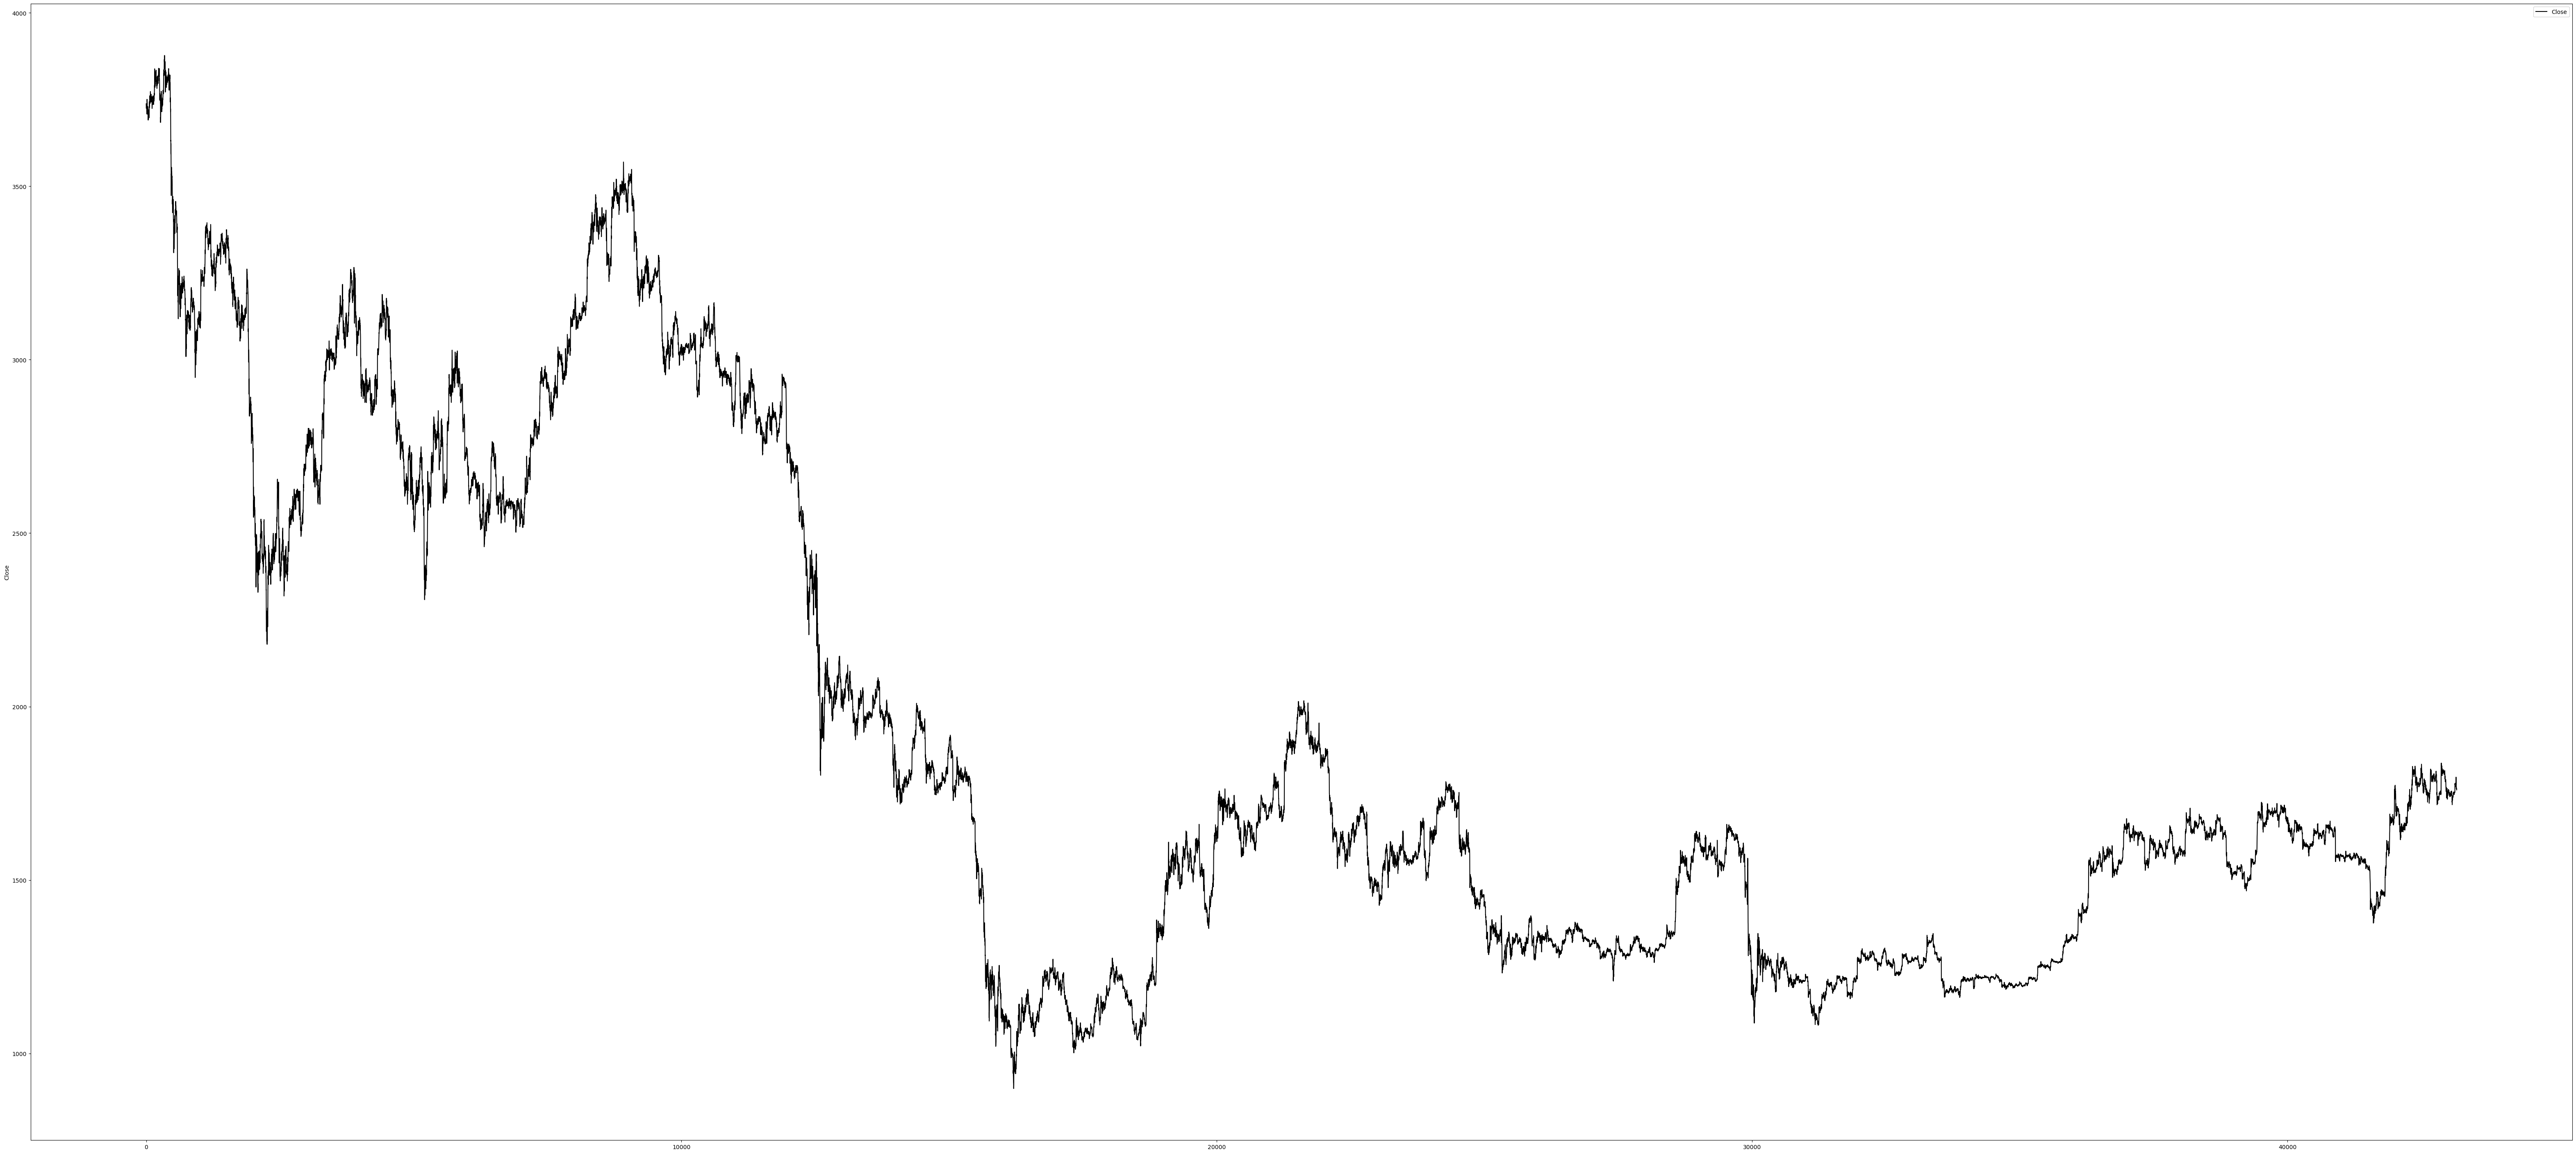

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()